# Introduction to Graph Science

## Lab 01: Generate artificial LFR social networks 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS6208_codes/codes/labs_lecture02'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd

In [2]:
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
from lib import *

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# LFR parameters
N = 1000
k = 10
maxk = k

# different community sizes
alpha = 0.0 # same community sizes
alpha = 0.5
minc = round((1-alpha)*N/k)
maxc = round((1+alpha)*N/k)

# mixing parameter
mu = 0.1

print(minc,maxc)

50 150


In [4]:
# Compile LFR code
!{'cd LFR; make; cd ..'}

# Run LFR code
cmd = './LFR/benchmark -N ' + str(N) + ' -k ' + str(k) + ' -maxk ' + str(maxk) + \
' -mu ' + str(mu) + ' -minc ' + str(minc) + ' -maxc ' + str(maxc)
print(cmd)
!{cmd}

g++ -O3 -funroll-loops -o benchmark ./Sources/benchm.cpp
In file included from ./Sources/benchm.cpp:34:
In file included from ./Sources/./standard_include.cpp:22:
./Sources/print.cpp:12:1: warning: non-void function does not return a value [-Wreturn-type]
}
^
./Sources/print.cpp:21:1: warning: non-void function does not return a value [-Wreturn-type]
}
^
In file included from ./Sources/benchm.cpp:34:
In file included from ./Sources/./standard_include.cpp:24:
./Sources/combinatorics.cpp:158:3: warning: add explicit braces to avoid dangling else [-Wdangling-else]
                else
                ^
./Sources/combinatorics.cpp:164:3: warning: add explicit braces to avoid dangling else [-Wdangling-else]
                else
                ^
In file included from ./Sources/benchm.cpp:34:
In file included from ./Sources/./standard_include.cpp:25:
./Sources/histograms.cpp:643:1: warning: non-void function does not return a value [-Wreturn-type]
}
^
./Sources/histograms.cpp:672:1: warning:

In [5]:
# Read LFR data:
#     'community.dat' contains the ground truth of communities from 1 to K
#     'network.dat' contains the edges of the LFR network

community = np.loadtxt('community.dat')
community = community[:,1]
print('nb of nodes=',community.shape[0])

network = np.loadtxt('network.dat')
network -= 1 # index starts at 0 with python
print('nb of edges=',network.shape[0])

nb of nodes= 1000
nb of edges= 10000


In [6]:
# Create LFR adjacency matrix W
nv = community.shape[0] # nb of vertices
ne = network.shape[0]
#print(nv,ne)

row = network[:,0]
col = network[:,1]
data = np.ones([ne])
#print(row.shape,col.shape,data.shape)

W = scipy.sparse.csr_matrix((data, (row, col)), shape=(nv, nv))
print(W.shape,type(W))

(1000, 1000) <class 'scipy.sparse._csr.csr_matrix'>


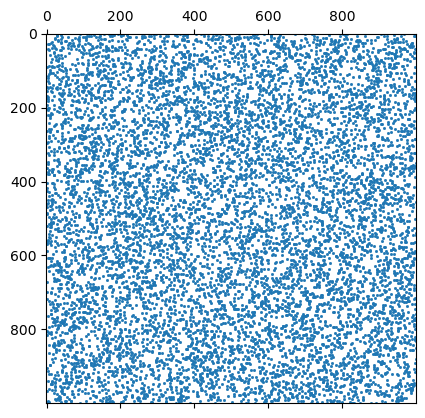

In [7]:
# Plot adjacency matrix
# Any data structure?
plt.figure(1)
plt.spy(W,precision=0.01, markersize=1)
plt.show()

In [8]:
######################################
# Function that reindexes W according to communities/classes
######################################

######################################
# Usage: 
#   [reindexed_W,reindexed_C] = reindex_W_with_C(W,C)
#
# Notations:
#   n = nb_data
#   nc = nb_communities
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#   C = Classes used for reindexing W. Size = n x 1. Values in [0,1,...,nc-1].
#
# Output variables:
#   reindexed_W = reindexed adjacency matrix. Size = n x n.
#   reindexed_C = reindexed classes C. Size = n x 1. Values in [0,1,...,nc-1].
######################################

def reindex_W_with_classes(W,C):
    n = C.shape[0] # nb of vertices
    nc = len(np.unique(C)) # nb of communities
    reindexing_mapping = np.zeros([n]) # mapping for reindexing W
    reindexed_C = np.zeros([n]) # reindexed C
    tot = 0
    for k in range(nc):
        cluster = (np.where(C==k))[0]
        length_cluster = len(cluster)
        x = np.array(range(tot,tot+length_cluster))
        reindexing_mapping[cluster] = x
        reindexed_C[x] = k
        tot += length_cluster
        
    idx_row,idx_col,val = scipy.sparse.find(W)
    idx_row = reindexing_mapping[idx_row]
    idx_col = reindexing_mapping[idx_col]
    reindexed_W = scipy.sparse.csr_matrix((val, (idx_row, idx_col)), shape=(n, n))

    return reindexed_W,reindexed_C

In [9]:
C = community - 1
[W,C] = reindex_W_with_classes(W,C)

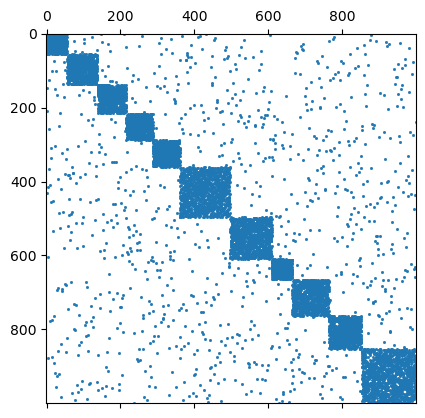

In [10]:
# Plot same W but according to communities
# Any structure?
plt.figure(2)
plt.spy(W,precision=0.01, markersize=1)
plt.show()

In [11]:
######################################
# Graph Laplacian Operator
######################################

######################################
# Usages: 
#   L = compute_graph_laplacian(W); # compute normalized graph Laplacian
#   L = compute_graph_laplacian(W,False); # compute UNnormalized graph Laplacian
#
# Notations:
#   n = nb_data
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#
# Output variables:
#   L = Graph Laplacian. Size = n x n.
######################################

def graph_laplacian(W, normalized=True):
    
    # Degree vector
    d = W.sum(axis=0)

    # Laplacian matrix
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype)) # d += epsilon
        d = 1.0 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D
    return L

In [12]:
######################################
# Visualization technique:
#   Belkin-Niyogi, Laplacian eigenmaps for dimensionality reduction and data representation, 2003
######################################

######################################
# Usage: 
#   [X,Y,Z] = compute_non_linear_dim_reduction(W)
#
# Notations:
#   n = nb_data
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#
# Output variables:
#   X = 1st data coordinates in low-dim manifold. Size n x 1.
#   Y = 2nd data coordinates in low-dim manifold. Size n x 1.
#   Z = 3rd data coordinates in low-dim manifold. Size n x 1.
######################################

def sort(lamb, U):
    idx = lamb.argsort()
    return lamb[idx], U[:,idx]

def compute_non_linear_dim_reduction(W):
    
    # Compute normalized graph Laplacian
    L = graph_laplacian(W)
    
    # Regularization for ill-posed graphs
    L = L + 1e-6* scipy.sparse.identity(L.shape[0], dtype=W.dtype)

    # Compute the first three Laplacian Eigenmaps
    lamb, U = scipy.sparse.linalg.eigsh(L, k=4, which='SM')
    
    # Sort eigenvalue from smallest to largest values
    lamb, U = sort(lamb, U)
    
    # Coordinates of graph vertices in the low-dim embedding manifold
    X = U[:,1]
    Y = U[:,2]
    Z = U[:,3]

    return X,Y,Z

[X,Y,Z] = compute_non_linear_dim_reduction(W)
#print(X.shape)

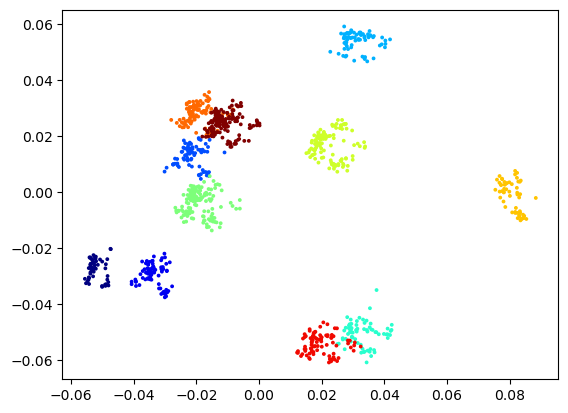

In [13]:
# Visualize the social network in 2D
plt.figure(3)
plt.scatter(X, Y, c=C, s=3, color=pyplot.jet())
plt.show()


In [14]:
# Visualize the social network in 3D
fig = pylab.figure(4)
ax = Axes3D(fig)
ax.scatter(X, Y, Z, c=C)
pyplot.show()

<Figure size 640x480 with 0 Axes>